In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import collections
from collections import defaultdict
import os
import sys
import mpl_toolkits
# import matplotlib.patheffects as path_effects
# from mpl_toolkits.mplot3d import Axes3D, art3d

project_path = os.path.expanduser('~/repos/metric_graph/')
sys.path.append(project_path)
sys.path.append('..')
from construct_graph.graph import Graph, Spherical
import construct_graph
import solve_laplace_operator

from calculations.helper_functions import style_plot

%load_ext autoreload
%autoreload 2

In [3]:
file = open("../data/delaunay/sphere_eigenvalues/sphere_eigenvalues.pkl", "rb")
eigenvalues = pickle.load(file)
file.close()

In [4]:
class Delaunay_Sphere(Graph, Spherical):

    """Parent class of more specific graph classes (spiderweb, delaunay triangulations etc.)
    These child classes need the attributes:
        - num_Vs DONE
        - V_coords DONE
        - E_lengths_by_v_num DONE
        - interior_V_num DONE
        - wadjacency_matrix DONE
    """

    def __init__(self, num_Vs):

        self.num_Vs = num_Vs
        self.construct_data()
        self.edges = self.construct_edges()
        self.g_coords = self.construct_g_coords()

    def construct_data(self):

        V_coords = np.random.normal(0, 1, size=(self.num_Vs, 3))
        V_coords /= np.linalg.norm(V_coords, axis=1, keepdims=True)

        # Construct edge set by Voronoi tesselation
        radius = 1
        center = np.array([0, 0, 0])
        sv = scipy.spatial.SphericalVoronoi(V_coords, radius, center)

        # Iterate over each Voronoi vertex
        vertex_to_regions = defaultdict(list)

        # Map each Voronoi vertex to the regions it belongs to
        for point_idx, region in enumerate(sv.regions):
            for vertex in region:
                vertex_to_regions[vertex].append(point_idx)

        edges = set()
        for region in vertex_to_regions.values():
            if len(region) != 3:
                raise ValueError(("Assumption that deg(Voronoi vertex) = 3 has been broken." 
                                  + "Probably not a problem, but there will be non-triangular faces in graph."))
            new_edges = [(region[0], region[1]), (region[1], region[2]), (region[0], region[2])]
            for edge in new_edges:
                edges.add(edge)

        E_lengths_by_v_num = {}
        for v_ind, w_ind in edges:
            E_lengths_by_v_num[v_ind, w_ind] = self.length_on_sphere(V_coords[v_ind], 
                                                                      V_coords[w_ind])
        
        # # Old (MUCH slower) method: Construct edge set by Delaunay triangulation
        # V_coords = np.vstack((V_coords, np.array(([0, 0, 0]))))

        # triangulation = scipy.spatial.Delaunay(V_coords)
        # self.triangulation = triangulation
        # print("triangulation built")

        # # Construct edges
        # triangulation = scipy.spatial.Delaunay(V_coords)
        # V, W = triangulation.vertex_neighbor_vertices
        # E_lengths_by_v_num = {}
        # for v_ind in range(self.num_Vs):
        #     w_inds = W[V[v_ind]:V[v_ind + 1]]
        #     for w_ind in w_inds:
        #         if (v_ind < w_ind) and (w_ind != self.num_Vs):
        #             E_lengths_by_v_num[v_ind, w_ind] = self.length_on_sphere(V_coords[v_ind], 
        #                                                                      V_coords[w_ind])
                    
        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v_ind, w_ind in E_lengths_by_v_num:
            wadjacency_matrix[v_ind, w_ind] = E_lengths_by_v_num[v_ind, w_ind]
            wadjacency_matrix[w_ind, v_ind] = E_lengths_by_v_num[v_ind, w_ind]
        wadjacency_matrix = wadjacency_matrix.tocsc()

        self.V_coords = V_coords
        self.E_lengths_by_v_num = E_lengths_by_v_num
        self.interior_V_num = np.arange(self.num_Vs)
        self.wadjacency_matrix = wadjacency_matrix

    def length_on_sphere(self, p1, p2, r=1):

        x1, y1, z1 = p1
        x2, y2, z2 = p2

        # Calculate the central angle between the two points
        dot_product = x1 * x2 + y1 * y2 + z1 * z2
        cos_theta = dot_product / (r**2)
        theta = np.arccos(np.clip(cos_theta, -1, 1))

        # Calculate the arc length
        arc_length = r * theta

        return arc_length
    
    def construct_edges(self):

        edges = []
        for v, w in self.E_lengths_by_v_num:
            edge = {"vw": (v, w), 
                    "l_vw": self.E_lengths_by_v_num[v, w],
                    "vw_coords": np.array((self.V_coords[v], self.V_coords[w]))}
            edges.append(edge)

        return edges

In [57]:
num_Vs, seed = 630, 0

np.random.seed(seed)
g = Delaunay_Sphere(num_Vs)

continuum_eigendata = solve_laplace_operator.solve_laplace_operator.Continuum_Eigendata("sphere")
proj = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalues[num_Vs][seed], continuum_eigendata)

proj(1, 0)
to_do = {num_Vs: proj.data.copy()}
data = solve_laplace_operator.solve_laplace_operator.Eigendata(to_do)

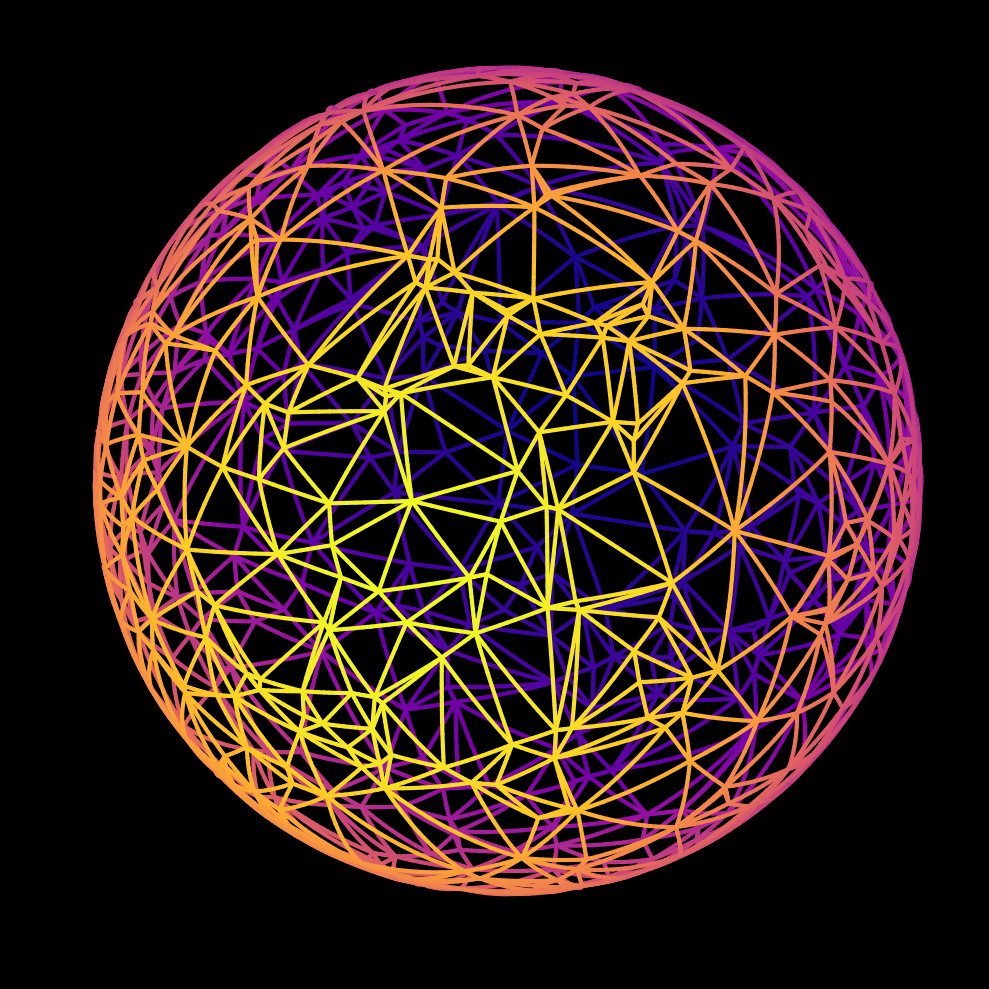

In [34]:
fig, ax = g.plot_graph(return_figax=True,
                       eigenmode=proj.data[1, 0]['graph']['eigenfunction'][2].data, 
                       linewidth=3, background_color="black")

plt.savefig("../figures/delaunay/spherical_graph_lm11.pdf", dpi=300, bbox_inches="tight")

plt.show()

In [58]:
x, y, z, eigenmode = proj.construct_pde_functions(1, 0, function_domain="continuum")

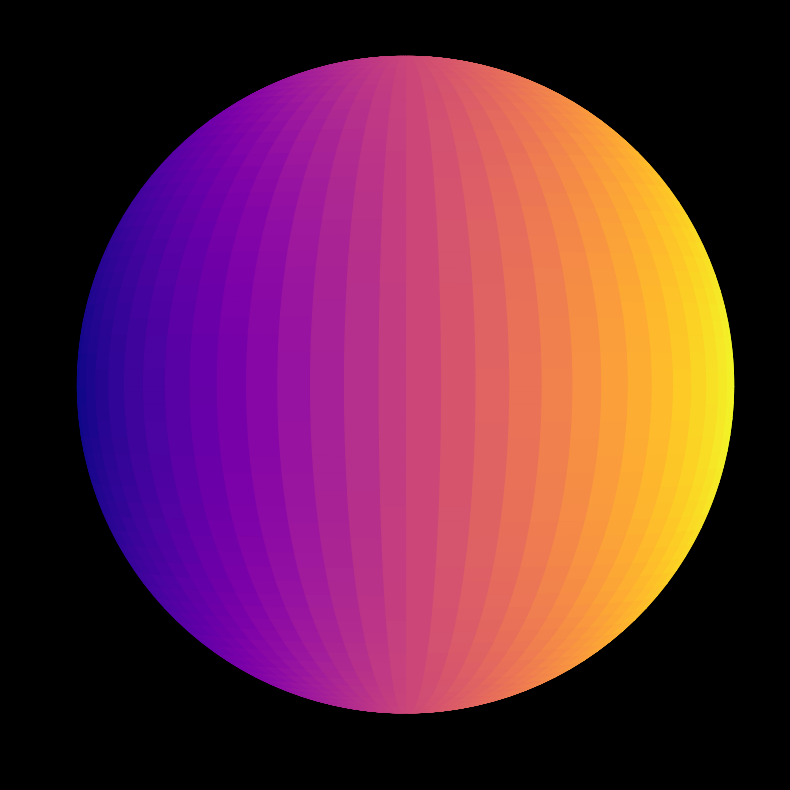

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

func = eigenmode[0]

ax.plot_surface(x, y, z, facecolors=plt.cm.plasma((func - func.min()) / (func.max() - func.min())), rstride=4, cstride=4, shade=False)
ax.view_init(0, 0)
ax.axis('off')
fig.set_facecolor("black")
ax.set_facecolor("black")
ax.set_xlim(-0.7, 0.7)
ax.set_ylim(-0.7, 0.7)
ax.set_zlim(-0.7, 0.7)

ax.set_aspect('equal')

plt.savefig("../figures/delaunay/spherical_PDE_lm1-1.pdf", dpi=300, bbox_inches="tight")

plt.show()

In [8]:
eigenvalues.keys()

dict_keys([100, 158, 251, 398, 630, 1000, 1584, 2511, 3981, 6309, 10000, 15848])

In [12]:
eigenvalue_difs = {}
eigenfunction_difs = {}

for num_Vs in eigenvalues:
    eigenvalue_difs[num_Vs] = []
    eigenfunction_difs[num_Vs] = []
    for seed in eigenvalues[num_Vs]:
        print(num_Vs, seed)

        np.random.seed(seed)

        g = Delaunay_Sphere(num_Vs)

        continuum_eigendata = solve_laplace_operator.solve_laplace_operator.Continuum_Eigendata("sphere")
        proj = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalues[num_Vs][seed], continuum_eigendata)

        proj(1, 0)
        to_do = {num_Vs: proj.data.copy()}
        data = solve_laplace_operator.solve_laplace_operator.Eigendata(to_do)

        eigenvalue_difs[num_Vs].append(data.relative_eigenvalue_differences[1, 0])
        eigenfunction_difs[num_Vs].append(data.relative_eigenfunction_differences[1, 0])

100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
100 20
100 21
100 22
100 23
100 24
100 25
100 26
100 27
100 28
100 29
100 30
100 31
100 32
100 33
100 34
100 35
100 36
100 37
100 38
100 39
100 40
100 41
100 42
100 43
100 44
100 45
100 46
100 47
100 48
100 49
100 50
100 51
100 52
100 53
100 54
100 55
100 56
100 57
100 58
100 59
100 60
100 61
100 62
100 63
100 64
100 65
100 66
100 67
100 68
100 69
100 70
100 71
100 72
100 73
100 74
100 75
100 76
100 77
100 78
100 79
100 80
100 81
100 82
100 83
100 84
100 85
100 86
100 87
100 88
100 89
100 90
100 91
100 92
100 93
100 94
100 95
100 96
100 97
100 98
100 99
100 100
100 101
100 102
100 103
100 104
100 105
100 106
100 107
100 108
100 109
100 110
100 111
100 112
100 113
100 114
100 115
100 116
100 117
100 118
100 119
100 120
100 121
100 122
100 123
100 124
100 125
100 126
100 127
100 128
100 129
100 130
100 131
100 132
100 133
100 134
100 135
100 136
100 137
100 13

In [27]:
nums_Vs = np.array(list(eigenfunction_difs.keys()))
vals = np.array([np.mean(i) for i in eigenfunction_difs.values()])

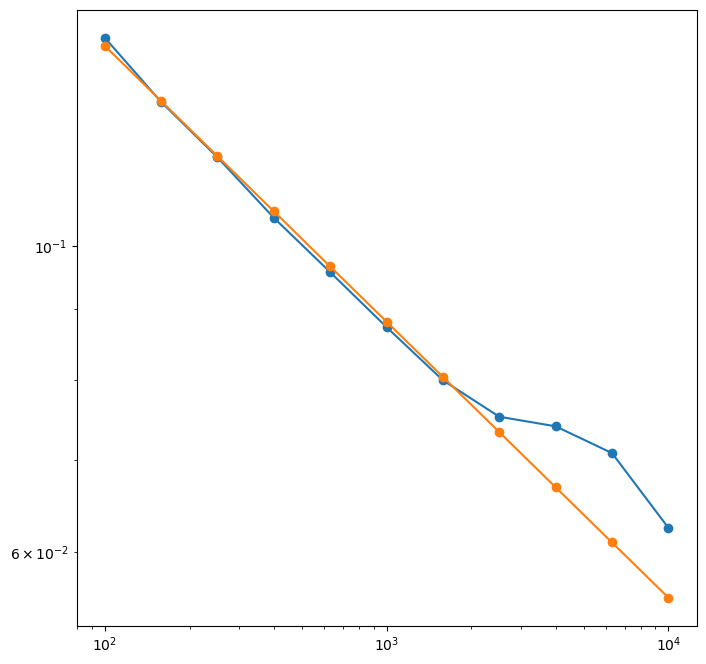

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.loglog(nums_Vs[:-1], vals[:-1], 'o-')
ax.loglog(nums_Vs[:-1], nums_Vs[:-1]**(-1/5) / 2.85, 'o-')

In [14]:
file = open("../data/delaunay/sphere_eigenfunction_difs/sphere_eigenfunction_difs.pkl", "wb")
pickle.dump(eigenfunction_difs, file)
file.close()